<a href="https://colab.research.google.com/github/RadhavaramHarika/Harika_INFO5731_Spring2020/blob/master/Harika_INFO5731_Assignment_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [0]:
# Write your code here
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import pandas as panda
import re
import numpy as nump
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plot
%matplotlib inline

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Initialize spacy 'en' model
nlp = spacy.load('en', disable=['parser', 'ner'])

def getReviews(filepath):
  name = ["Total_Reviews"]
  data = panda.read_csv(filepath,usecols = [2],names=name)
  return data.Total_Reviews.values.tolist()[1:]

def tokenization(ReviewsList):
    for sentence in ReviewsList:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def stopwords_removal(reviewTokens):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in reviewTokens]

def build_bigrams_model(reviewTokensList):
  bigram = gensim.models.Phrases(reviewTokensList, min_count=5, threshold=100)
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  return (bigram,bigram_mod)

def build_trigrams_model(reviewTokensList,bigrms):
  trigram = gensim.models.Phrases(bigrms[reviewTokensList], threshold=100)  
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  return trigram_mod

def reviews_bigrams(reviewTokens,model):
  return [model[doc] for doc in reviewTokens]

def reviews_trigrams(reviewTokens,bgrm_mod,tgrm_mod):
  return [tgrm_mod[bgrm_mod[doc]] for doc in reviewTokens]

def reviews_lemmatization(reviewTokens, allowed_pos=['NOUN', 'ADJ', 'VERB', 'ADV']):
    review_lemmas = []
    for tokens in reviewTokens:
        doc = nlp(" ".join(tokens)) 
        review_lemmas.append([token.lemma_ for token in doc if token.pos_ in allowed_pos])
    return review_lemmas

inputPath = "https://raw.githubusercontent.com/RadhavaramHarika/Harika_INFO5731_Spring2020/master/UserReview.csv"
reviews_data = getReviews(inputPath)

reviews_tokens = list(tokenization(reviews_data))

print(reviews_tokens)

bi_grams_model = build_bigrams_model(reviews_tokens)

tri_gram_model = build_trigrams_model(reviews_tokens,bi_grams_model[0])

reviews_nostops = stopwords_removal(reviews_tokens)

reviews_bigram_words = reviews_bigrams(reviews_nostops,bi_grams_model[1])

lemmatized_reviews = reviews_lemmatization(reviews_bigram_words, allowed_pos=['NOUN', 'ADJ', 'VERB', 'ADV'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[['was', 'person', 'that', 'saw', 'all', 'the', 'hype', 'and', 'claims', 'of', 'masterpiece', 'as', 'overreacting', 'and', 'overblown', 'excitement', 'for', 'another', 'joker', 'based', 'film', 'thought', 'this', 'looked', 'solid', 'at', 'best', 'and', 'even', 'bit', 'too', 'pretentious', 'in', 'the', 'trailer', 'but', 'in', 'here', 'to', 'say', 'was', 'incredibly', 'wrong', 'this', 'is', 'massive', 'achievement', 'of', 'cinema', 'that', 'extremely', 'rare', 'in', 'day', 'and', 'age', 'of', 'cgi', 'nonsense', 'and', 'reboots', 'while', 'this', 'is', 'somewhat', 'of', 'reboot', 'of', 'sorts', 'the', 'standalone', 'origin', 'tale', 'is', 'impeccable', 'from', 'start', 'to', 'finish', 'and', 'echoes', 'resemblance', 'to', 'the', 'best', 'joker', 'origin', 'comics', 'from', 'the', 'past', 'joaquin', 'bleeds', 'sweats', 'and', 'cries', 'his', 'every', 'drop', 'into', 'this'

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Phrases<7962 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
[['person', 'saw', 'hype', 'claims', 'masterpiece', 'overreacting', 'overblown', 'excitement', 'another', 'joker', 'based', 'film', 'thought', 'looked', 'solid', 'best', 'even', 'bit', 'pretentious', 'trailer', 'say', 'incredibly', 'wrong', 'massive', 'achievement', 'cinema', 'extremely', 'rare', 'day', 'age', 'cgi', 'nonsense', 'reboots', 'somewhat', 'reboot', 'sorts', 'standalone', 'origin', 'tale', 'impeccable', 'start', 'finish', 'echoes', 'resemblance', 'best', 'joker', 'origin', 'comics', 'past', 'joaquin', 'bleeds', 'sweats', 'cries', 'every', 'drop', 'magnificently', 'dedicated', 'performance', 'heath_ledger', 'would', 'proud', 'undoubtedly', 'greatest', 'acting', 'performance', 'since', 'heath', 'joker', 'directing', 'writing', 'slickly', 'brilliant', 'bleak', 'settings', 'tones', 'palpable', 'throughout', 'film', 'place', 'blown', 'away', 'every', 'audience', 'member', 'awestruck', 'witnessed', 'film', '

In [0]:
def dict_corpus(reviews_lemmas):
  id2word = corpora.Dictionary(reviews_lemmas)
  corpus = [id2word.doc2bow(review) for review in reviews_lemmas]
  return id2word,corpus

rev_dict, corpus =  dict_corpus(lemmatized_reviews)

print("Term frequencies in first Review:\n")
[[(rev_dict[id], freq) for id, freq in cp] for cp in corpus[:1]]


Term frequencies in first Review:



[[('achievement', 1),
  ('act', 1),
  ('age', 1),
  ('audience', 1),
  ('awestruck', 1),
  ('base', 1),
  ('believe', 1),
  ('best', 1),
  ('bit', 1),
  ('bleak', 1),
  ('bleed', 1),
  ('blow', 1),
  ('brilliant', 1),
  ('cgi', 1),
  ('character', 1),
  ('cinema', 1),
  ('claim', 1),
  ('comic', 1),
  ('could', 1),
  ('cry', 1),
  ('day', 1),
  ('dedicated', 1),
  ('direct', 1),
  ('drop', 1),
  ('echo', 1),
  ('even', 1),
  ('excitement', 1),
  ('existence', 1),
  ('extremely', 1),
  ('film', 3),
  ('finish', 1),
  ('go', 1),
  ('good', 1),
  ('great', 1),
  ('hype', 1),
  ('impeccable', 1),
  ('incredibly', 1),
  ('joker', 1),
  ('look', 1),
  ('magnificently', 1),
  ('massive', 1),
  ('masterpiece', 2),
  ('member', 1),
  ('nonsense', 1),
  ('origin', 1),
  ('overblown', 1),
  ('overreact', 1),
  ('palpable', 1),
  ('performance', 2),
  ('person', 1),
  ('place', 1),
  ('pretentious', 1),
  ('proud', 1),
  ('rare', 1),
  ('reboot', 2),
  ('revere', 1),
  ('say', 1),
  ('see', 1),
  

In [0]:
from gensim.models import LdaModel

def create_gensim_lda_model(number_of_topics,words):
  lda_model = LdaModel(corpus,num_topics=number_of_topics,id2word=rev_dict,passes=20,chunksize = 100)
  print(lda_model.print_topics(num_topics=number_of_topics, num_words=10))
  return lda_model

lda_model1 = create_gensim_lda_model(10,10)
print("10 Topics:\n")
lda_model1.show_topics(formatted=False)



[(0, '0.043*"film" + 0.018*"movie" + 0.013*"character" + 0.013*"people" + 0.009*"would" + 0.009*"go" + 0.009*"watch" + 0.009*"way" + 0.008*"world" + 0.008*"even"'), (1, '0.034*"film" + 0.031*"plot" + 0.025*"cinematography" + 0.024*"year" + 0.021*"incredible" + 0.019*"say" + 0.017*"movie" + 0.015*"feel" + 0.014*"great" + 0.014*"empty"'), (2, '0.049*"movie" + 0.014*"think" + 0.012*"make" + 0.012*"review" + 0.012*"feel" + 0.010*"much" + 0.010*"theme" + 0.010*"superhero" + 0.010*"say" + 0.009*"really"'), (3, '0.058*"movie" + 0.019*"way" + 0.017*"see" + 0.015*"people" + 0.013*"end" + 0.012*"story" + 0.012*"watch" + 0.012*"think" + 0.010*"make" + 0.010*"feel"'), (4, '0.033*"perfect" + 0.022*"performance" + 0.017*"film" + 0.017*"character" + 0.017*"show" + 0.017*"story" + 0.017*"music" + 0.011*"act" + 0.011*"many" + 0.011*"cinematography"'), (5, '0.023*"good" + 0.021*"scene" + 0.020*"movie" + 0.013*"go" + 0.013*"real" + 0.013*"become" + 0.011*"time" + 0.010*"make" + 0.010*"turn" + 0.010*"see"

[(0,
  [('film', 0.042770613),
   ('movie', 0.01755399),
   ('character', 0.012884257),
   ('people', 0.012869452),
   ('would', 0.0094132805),
   ('go', 0.009324681),
   ('watch', 0.009279551),
   ('way', 0.008767504),
   ('world', 0.0082019605),
   ('even', 0.007884694)]),
 (1,
  [('film', 0.034239527),
   ('plot', 0.031447954),
   ('cinematography', 0.024765423),
   ('year', 0.023683345),
   ('incredible', 0.02074889),
   ('say', 0.018634865),
   ('movie', 0.01723061),
   ('feel', 0.015388113),
   ('great', 0.014313505),
   ('empty', 0.01390734)]),
 (2,
  [('movie', 0.048748635),
   ('think', 0.014206617),
   ('make', 0.012467787),
   ('review', 0.012316698),
   ('feel', 0.011911681),
   ('much', 0.010455126),
   ('theme', 0.009989883),
   ('superhero', 0.009989586),
   ('say', 0.009615123),
   ('really', 0.009468322)]),
 (3,
  [('movie', 0.058446735),
   ('way', 0.018719008),
   ('see', 0.017145956),
   ('people', 0.014795755),
   ('end', 0.0128391925),
   ('story', 0.011857943),
 

In [0]:
print('\nPerplexity of above LDA Model: ', lda_model1.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model1, texts=lemmatized_reviews, dictionary=rev_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score on above LDA Model: ', coherence_lda)


Perplexity of above LDA Model:  -6.279343123111051

Coherence Score on above LDA Model:  0.3408830642517296


In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model1, corpus, rev_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.034436 -0.162655       1        1  25.143150
7     -0.036702 -0.051072       2        1  15.417939
2     -0.083745  0.011255       3        1  14.967818
3     -0.160638  0.023047       4        1  12.352294
6     -0.083409 -0.029938       5        1  12.040829
5     -0.024968  0.153262       6        1   8.071549
1      0.101092 -0.030402       7        1   4.441584
4      0.176559 -0.061208       8        1   3.380384
8      0.087932  0.127127       9        1   3.281281
9      0.058316  0.020585      10        1   0.903179, topic_info=        Term        Freq       Total Category  logprob  loglift
29      film  115.000000  115.000000  Default  30.0000  30.0000
95     movie  290.000000  290.000000  Default  29.0000  29.0000
331     plot   28.000000   28.000000  Default  28.0000  28.0000
33     great   43.000000   43.000000  Default  27.0000  27.0000
423  perfect   19.000000   19.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
115     feel    0.408273   64.902199  Topic10  -5.0816  -0.3617
151     much    0.408236   26.340155  Topic10  -5.0817   0.5400
31        go    0.408226   55.198811  Topic10  -5.0817  -0.1999
238    scene    0.408197   22.765928  Topic10  -5.0818   0.6857
237   review    0.408190   25.788658  Topic10  -5.0818   0.5610

[643 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
395       2  0.125681  absolutely
395       3  0.754084  absolutely
395       4  0.125681  absolutely
1148      6  0.925448       abuse
192       8  0.688208  accomplish
...     ...       ...         ...
355       1  0.334059        year
355       5  0.055677        year
355       6  0.167030        year
355       7  0.445412        year
317       9  0.687612   yesterday

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 3, 4, 7, 6, 2, 5, 9, 10])

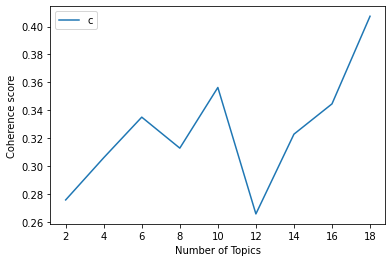

Num Topics = 2  has Coherence Value of 0.276
Num Topics = 4  has Coherence Value of 0.3062
Num Topics = 6  has Coherence Value of 0.3352
Num Topics = 8  has Coherence Value of 0.313
Num Topics = 10  has Coherence Value of 0.3564
Num Topics = 12  has Coherence Value of 0.266
Num Topics = 14  has Coherence Value of 0.323
Num Topics = 16  has Coherence Value of 0.3447
Num Topics = 18  has Coherence Value of 0.4074
LdaModel(num_terms=1201, num_topics=18, decay=0.5, chunksize=100) 0.4073501233929608


In [0]:
def compute_coherence_values(dictionary, corpus, clean_doc, start,stop):
  coherence_values = []
  model_list = []
  for num_topics in range(start, stop,2):
      # generate LSA model
      model = LdaModel(corpus, num_topics=num_topics, id2word = dictionary,chunksize =100,passes =20)  # train model
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=clean_doc, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())
  return model_list, coherence_values

def plot_graph(clean_doc,start, stop):
  model_list, coherence_values = compute_coherence_values(rev_dict, corpus,clean_doc, start,stop)

  x = range(start, stop, 2)
  plot.plot(x, coherence_values)
  plot.xlabel("Number of Topics")
  plot.ylabel("Coherence score")
  plot.legend(("coherence_values"), loc='best')
  plot.show()

  for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
  indx = coherence_values.index(max(coherence_values))
  print(model_list[indx],coherence_values[indx])

  return (model_list[indx],coherence_values[indx])

optimal_model = plot_graph(lemmatized_reviews,2,20)



In [0]:
optimal_model[0].show_topics(formatted = True)


[(4,
  '0.065*"movie" + 0.016*"character" + 0.016*"film" + 0.013*"think" + 0.012*"joker" + 0.012*"would" + 0.010*"good" + 0.010*"see" + 0.010*"far" + 0.010*"come"'),
 (13,
  '0.048*"take" + 0.033*"story" + 0.032*"movie" + 0.023*"get" + 0.020*"good" + 0.019*"ever" + 0.016*"score" + 0.015*"film" + 0.015*"hand" + 0.015*"see"'),
 (15,
  '0.039*"great" + 0.039*"movie" + 0.035*"plot" + 0.024*"film" + 0.021*"character" + 0.020*"year" + 0.017*"good" + 0.016*"say" + 0.015*"cinematography" + 0.015*"act"'),
 (12,
  '0.052*"film" + 0.017*"performance" + 0.017*"watch" + 0.015*"go" + 0.014*"see" + 0.013*"people" + 0.011*"still" + 0.011*"even" + 0.010*"character" + 0.010*"simply"'),
 (6,
  '0.001*"film" + 0.001*"watch" + 0.001*"see" + 0.001*"performance" + 0.001*"go" + 0.001*"lot" + 0.001*"still" + 0.001*"say" + 0.001*"even" + 0.001*"moment"'),
 (9,
  '0.042*"movie" + 0.025*"good" + 0.017*"performance" + 0.017*"year" + 0.013*"ever" + 0.013*"scene" + 0.013*"deliver" + 0.013*"way" + 0.013*"say" + 0.013

In [0]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model[0], corpus, rev_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.125799  0.006011       1        1  28.158459
12     0.133528  0.053128       2        1  11.316171
5      0.116202  0.102128       3        1   8.292906
14     0.052702 -0.117589       4        1   8.070229
10    -0.090606 -0.133782       5        1   6.378278
8      0.107890 -0.026677       6        1   6.312534
11    -0.184914  0.160779       7        1   5.995053
15     0.065621  0.119558       8        1   5.902880
7      0.049164 -0.164591       9        1   5.040496
1      0.019808  0.006548      10        1   3.820839
0     -0.051672  0.065363      11        1   3.025143
2     -0.101938 -0.059966      12        1   2.392221
9      0.020743  0.026315      13        1   2.288385
13    -0.063427  0.010918      14        1   1.848674
3     -0.115695 -0.015039      15        1   1.074233
6     -0.083208 -0.033105      16        1   0.083501, topic_info=          Term        Freq       Total Category  logprob  loglift
95       movie  293.000000  293.000000  Default  30.0000  30.0000
243       take   45.000000   45.000000  Default  29.0000  29.0000
29        film  115.000000  115.000000  Default  28.0000  28.0000
32        good   75.000000   75.000000  Default  27.0000  27.0000
115       feel   65.000000   65.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
11        blow    0.005083    7.192154  Topic16  -7.0866  -0.1668
287       lead    0.005083   10.559912  Topic16  -7.0866  -0.5509
37       joker    0.005082   65.615410  Topic16  -7.0867  -2.3777
214      actor    0.005082   19.910192  Topic16  -7.0868  -1.1852
917  greatness    0.005082    9.130603  Topic16  -7.0868  -0.4057

[925 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
356       1  0.130439        able
356       6  0.652196        able
356       8  0.130439        able
395       1  0.848411  absolutely
395       9  0.121202  absolutely
...     ...       ...         ...
355      13  0.162278        year
317      10  0.644847   yesterday
692       2  0.369676         yet
692       7  0.369676         yet
692      14  0.246451         yet

[1292 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 13, 6, 15, 11, 9, 12, 16, 8, 2, 1, 3, 10, 14, 4, 7])

In [0]:
def format_topics_sentences(ldamodel, corpus, reviews):
  rev_topics_df = panda.DataFrame()

  for i, row in enumerate(ldamodel[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0: 
          wp = ldamodel.show_topic(topic_num)
          topic_keywords = ", ".join([word for word, prop in wp])
          rev_topics_df = rev_topics_df.append(panda.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
          break
  rev_topics_df.columns = ['Dominant_Topic', 'Topic_cont_percent', 'Topic_Keywords']

  contents = panda.Series(reviews)
  rev_topics_df = panda.concat([rev_topics_df, contents], axis=1)
  return(rev_topics_df)

df_topic_rev_keywords = format_topics_sentences(optimal_model[0],corpus,reviews_data)

df_dominant_topic = df_topic_rev_keywords.reset_index()
df_dominant_topic.columns = ['Review_No', 'Dominant_Topic', 'Topic_cont_percent', 'Keywords', 'Reviews']

df_dominant_topic.to_csv("Reviews_LDA.csv")
df_dominant_topic.head(10)

,Review_No,Dominant_Topic,Topic_cont_percent,Keywords,Reviews
0,0,8.0,0.6041,"movie, go, crazy, mean, character, way, call, ...",I was a person that saw all the hype and claim...
1,1,15.0,0.9766,"great, movie, plot, film, character, year, goo...","Every once in a while a movie comes, that trul..."
2,2,5.0,0.9732,"movie, good, feel, people, think, see, watch, ...",This is a movie that only those who have felt ...
3,3,14.0,0.9866,"movie, joker, become, make, film, whole, feel,...","Truly a masterpiece, The Best Hollywood film o..."
4,4,14.0,0.9753,"movie, joker, become, make, film, whole, feel,...",Most of the time movies are anticipated like t...
5,5,12.0,0.9724,"film, performance, watch, go, see, people, sti...",Joaquin Phoenix gives a tour de force performa...
6,6,4.0,0.4183,"movie, character, film, think, joker, would, g...",Let me start off by saying if Joaquin Phoneix ...
7,7,0.0,0.4860,"perfect, music, story, show, feel, would, real...",I get why some people hate this . It's because...
8,8,1.0,0.9911,"movie, film, make, good, feel, time, see, take...",I have seen Joker yesterday at Venice an early...
9,9,4.0,0.8950,"movie, character, film, think, joker, would, g...",It's sad that Joaquin missed Oscar for 'The gl...


In [0]:
topic_counts = df_topic_rev_keywords['Dominant_Topic'].value_counts()

topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_rev_keywords[['Dominant_Topic', 'Topic_Keywords']]

df_dominant_topics = panda.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Reviews', 'Percent_Review']

df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Reviews,Percent_Review
0.0,8.0,"movie, go, crazy, mean, character, way, call, ...",7.0,0.07
1.0,15.0,"great, movie, plot, film, character, year, goo...",3.0,0.03
2.0,5.0,"movie, good, feel, people, think, see, watch, ...",3.0,0.03
3.0,14.0,"movie, joker, become, make, film, whole, feel,...",3.0,0.03
4.0,14.0,"movie, joker, become, make, film, whole, feel,...",21.0,0.21
...,...,...,...,...
95.0,3.0,"make, work, give, trouble, watch, performance,...",NaN,NaN
96.0,10.0,"scene, become, real, make, movie, joker, go, e...",NaN,NaN
97.0,4.0,"movie, character, film, think, joker, would, g...",NaN,NaN
98.0,8.0,"movie, go, crazy, mean, character, way, call, ...",NaN,NaN


# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. 

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [0]:
# Write your code here





# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/INFO5731_Spring2020/blob/master/Assignments/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [0]:
# Write your code here
import matplotlib.pyplot as plt
import seaborn as sns

#Using functions to read data from csv file
def readingCSV(filePath):
    filedata = panda.read_csv(filePath)
    return filedata

#calling above function to read csv data with a file path
file_path = "https://raw.githubusercontent.com/RadhavaramHarika/Harika_INFO5731_Spring2020/master/train_q3.csv"
train_data = readingCSV(file_path) 

#printing the results of csv data reading
train_data.head(10)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [0]:
#Using functions to verify missing values in the dataset
def verifyMissingValuesInData(fileData):
  panda.set_option('display.max_rows', None)
  print(fileData.isnull().sum())
  
  return

def cleanData(columnList,fileData):
  fileData[columnList]=fileData[columnList].replace(nump.NaN,0)
  return fileData

#Calling above function to verify missing values and print results
print("Verifying Missing values in train dataset: \n")
verifyMissingValuesInData(train_data)

columns_clean = ['LotFrontage','Alley','BsmtQual','BsmtCond','BsmtExposure',
                 'BsmtFinType1','Electrical','BsmtFinType2','FireplaceQu','GarageType',
                 'GarageYrBlt','GarageFinish','GarageQual','GarageCond',
                 'PoolQC','Fence','MiscFeature','MasVnrType','MasVnrArea']
cleanData(columns_clean,train_data)
print("Verifying Missing values in train dataset after cleaning: \n")
verifyMissingValuesInData(train_data)



Verifying Missing values in train dataset: 

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       8
MasVnrArea       8
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfB

In [0]:
#Using functions to describe the dataset
def descData(fileData,name):
    print("Dimension of the "+name+" dataset: \n",fileData.shape)
    print("\nData Types of the "+name+" dataset: \n",fileData.dtypes)
    print("\nView of the first 10 records of "+name+" dataset: \n",fileData.head(10))
    print("\nSummary of the "+name+" dataset: \n",fileData.describe())
    return

#Calling above function to print dataset description
descData(train_data,'train')

Dimension of the train dataset: 
 (1460, 81)

Data Types of the train dataset: 
 Id                 int64
MSSubClass         int64
MSZoning            int8
LotFrontage      float64
LotArea            int64
Street              int8
Alley               int8
LotShape            int8
LandContour         int8
Utilities           int8
LotConfig           int8
LandSlope           int8
Neighborhood        int8
Condition1          int8
Condition2          int8
BldgType            int8
HouseStyle          int8
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle           int8
RoofMatl            int8
Exterior1st         int8
Exterior2nd         int8
MasVnrType          int8
MasVnrArea       float64
ExterQual           int8
ExterCond           int8
Foundation          int8
BsmtQual            int8
BsmtCond            int8
BsmtExposure        int8
BsmtFinType1        int8
BsmtFinSF1         int64
BsmtFinType2        int8
BsmtFinSF2         

In [0]:

#Using functions to convert every categorical column from the dataset into numeric 
def convertCatIntoNumeric(fileData):
  cat_columns = list(fileData.select_dtypes(['object']).columns)
  print(cat_columns)
  fileData[cat_columns] = fileData[cat_columns].apply(lambda x: x.astype('category'))
  fileData[cat_columns] = fileData[cat_columns].apply(lambda x: x.cat.codes)
  return fileData

#Calling above function to convert categorical column to numeric
convertCatIntoNumeric(train_data)

#Againg calling above function to describe datframe columns after changing categorical to numeric in preprocessing
descData(train_data,'train')

[]
Dimension of the train dataset: 
 (1460, 81)

Data Types of the train dataset: 
 Id                 int64
MSSubClass         int64
MSZoning            int8
LotFrontage      float64
LotArea            int64
Street              int8
Alley               int8
LotShape            int8
LandContour         int8
Utilities           int8
LotConfig           int8
LandSlope           int8
Neighborhood        int8
Condition1          int8
Condition2          int8
BldgType            int8
HouseStyle          int8
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle           int8
RoofMatl            int8
Exterior1st         int8
Exterior2nd         int8
MasVnrType          int8
MasVnrArea       float64
ExterQual           int8
ExterCond           int8
Foundation          int8
BsmtQual            int8
BsmtCond            int8
BsmtExposure        int8
BsmtFinType1        int8
BsmtFinSF1         int64
BsmtFinType2        int8
BsmtFinSF2      

In [0]:
test_path = "https://raw.githubusercontent.com/RadhavaramHarika/Harika_INFO5731_Spring2020/master/test_q3.csv"
test_data = readingCSV(test_path) 

#printing the results of csv data reading
test_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,892,0,1655,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,676,0,1465,0.0,0.0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,393.0,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.0,0.0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.0,Unf,2.0,506.0,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,

In [0]:
#Calling above function to verify missing values and print results
print("Verifying Missing values in test dataset: \n")
verifyMissingValuesInData(test_data) 
columns_clean = ['LotFrontage','Alley','Utilities','Exterior1st','Exterior2nd','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                  'BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                 'BsmtFullBath','BsmtHalfBath','KitchenQual','Functional','FireplaceQu','GarageType',
                 'GarageYrBlt','GarageFinish','GarageQual','GarageCond',
                 'PoolQC','Fence','MiscFeature','SaleType','MasVnrArea']
cleanData(columns_clean,test_data)
print("Verifying Missing values in test dataset after cleaning: \n")
verifyMissingValuesInData(test_data)

Verifying Missing values in test dataset: 

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          0
BsmtFinType2       42
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF  

In [0]:
#Calling above function to print dataset description
descData(test_data,'test')

Dimension of the test dataset: 
 (1459, 80)

Data Types of the test dataset: 
 Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       floa

In [0]:
#Calling above function to convert categorical column to numeric
convertCatIntoNumeric(test_data)

#Againg calling above function to describe datframe columns after changing categorical to numeric in preprocessing
descData(test_data,'test')

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Dimension of the test dataset: 
 (1459, 80)

Data Types of the test dataset: 
 Id                 int64
MSSubClass         int64
MSZoning            int8
LotFrontage      float64
LotArea            int64
Street              int8
Alley               int8
LotShape            int8
LandContour         int8
Utilities           int8
LotConfig           int8
LandSlope           int8
Neighborhood        int8
Condition1      

In [0]:
correlation = train_data.corr(method='pearson')
panda.set_option('display.max_columns', None)
print(correlation['SalePrice'])
         
OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,
BsmtFinSF1,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,
KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQuGarageCars,GarageArea       


Id              -0.021917
MSSubClass      -0.084284
MSZoning        -0.166872
LotFrontage      0.209624
LotArea          0.263843
Street           0.041036
Alley           -0.092607
LotShape        -0.255580
LandContour      0.015453
Utilities       -0.014314
LotConfig       -0.067396
LandSlope        0.051152
Neighborhood     0.210851
Condition1       0.091155
Condition2       0.007513
BldgType        -0.085591
HouseStyle       0.180163
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
RoofStyle        0.222405
RoofMatl         0.132383
Exterior1st      0.103551
Exterior2nd      0.103766
MasVnrType      -0.000488
MasVnrArea       0.472614
ExterQual       -0.636884
ExterCond        0.117303
Foundation       0.382479
BsmtQual        -0.438881
BsmtCond         0.147367
BsmtExposure    -0.193079
BsmtFinType1    -0.013233
BsmtFinSF1       0.386420
BsmtFinType2     0.130814
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF 

In [0]:
#Using functions to split dataset into input,output and to convert into array
def splittingInpOut(fileData):
    ar_data = nump.array(fileData)
    X = fileData[['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','ExterQual',
                  'BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath',
                  'KitchenQual','TotRmsAbvGrd','Fireplaces','FireplaceQu',
                  'GarageCars','GarageArea']].values
    y = fileData['SalePrice'].values
    return (ar_data,X,y)

#Calling above function to split train data and printing its results
train_ar = splittingInpOut(train_data)[0]
train_X_data = splittingInpOut(train_data)[1]
train_y_data = splittingInpOut(train_data)[2]

print("Array of the dataset: \n",train_ar)
print("\nTrain Input data X: \n",train_X_data)
print("\nTrain Output data Y: \n",train_y_data)

Array of the dataset: 
 [[1.00000e+00 6.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  2.08500e+05]
 [2.00000e+00 2.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  1.81500e+05]
 [3.00000e+00 6.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  2.23500e+05]
 ...
 [1.45800e+03 7.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  2.66500e+05]
 [1.45900e+03 2.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  1.42125e+05]
 [1.46000e+03 2.00000e+01 3.00000e+00 ... 8.00000e+00 4.00000e+00
  1.47500e+05]]

Train Input data X: 
 [[7.000e+00 2.003e+03 2.003e+03 ... 0.000e+00 2.000e+00 5.480e+02]
 [6.000e+00 1.976e+03 1.976e+03 ... 5.000e+00 2.000e+00 4.600e+02]
 [7.000e+00 2.001e+03 2.002e+03 ... 5.000e+00 2.000e+00 6.080e+02]
 ...
 [7.000e+00 1.941e+03 2.006e+03 ... 3.000e+00 1.000e+00 2.520e+02]
 [5.000e+00 1.950e+03 1.996e+03 ... 0.000e+00 1.000e+00 2.400e+02]
 [5.000e+00 1.965e+03 1.965e+03 ... 0.000e+00 1.000e+00 2.760e+02]]

Train Output data Y: 
 [208500 181500 223500 ... 266

In [0]:
#Calling above function to split train data and printing its results
test_ar = ar_data = nump.array(test_data)
test_X_data = test_data[['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','ExterQual',
                  'BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath',
                  'KitchenQual','TotRmsAbvGrd','Fireplaces','FireplaceQu',
                  'GarageCars','GarageArea']].values

print("Array of the Test dataset: \n",test_ar)
print("\nTest Input data X: \n",test_X_data)

Array of the Test dataset: 
 [[1461.   20.    3. ... 2010.    9.    4.]
 [1462.   20.    4. ... 2010.    9.    4.]
 [1463.   60.    4. ... 2010.    9.    4.]
 ...
 [2917.   20.    4. ... 2006.    9.    0.]
 [2918.   85.    4. ... 2006.    9.    4.]
 [2919.   60.    4. ... 2006.    9.    4.]]

Test Input data X: 
 [[5.000e+00 1.961e+03 1.961e+03 ... 0.000e+00 1.000e+00 7.300e+02]
 [6.000e+00 1.958e+03 1.958e+03 ... 0.000e+00 1.000e+00 3.120e+02]
 [5.000e+00 1.997e+03 1.998e+03 ... 5.000e+00 2.000e+00 4.820e+02]
 ...
 [5.000e+00 1.960e+03 1.996e+03 ... 5.000e+00 2.000e+00 5.760e+02]
 [5.000e+00 1.992e+03 1.992e+03 ... 0.000e+00 0.000e+00 0.000e+00]
 [7.000e+00 1.993e+03 1.994e+03 ... 5.000e+00 3.000e+00 6.500e+02]]


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#Using functions to build and train the linear regression model
def linRegression(x_train,y_train,x_test):
    regressor = LinearRegression()  
    regressor.fit(x_train, y_train)
    return regressor,regressor.predict(x_test)

#Calling above function to train and predict test output data
model,predicted_y = linRegression(train_X_data,train_y_data,test_X_data)

#Printing Predicted values

print("Predicted Sale Prices for Test Data")
data = panda.DataFrame({'Predicted_SalePrice': predicted_y})
reg_data = data.head(30)
reg_data

Predicted Sale Prices for Test Data


,Predicted_SalePrice
0,92425.047319
1,150006.078948
2,156604.852541
3,183330.630365
4,195296.844255
5,154935.845251
6,157275.833048
7,153412.283157
8,186835.542072
9,96031.559549
